# The L-Curve

Due both to the sparseness of the global observing network, and also to the efficiency of atmospheric mixing at erasing gradients arising fromsurface fluxes, the atmospheric inversion problem is frequently underdetermined.  In the face of such ill-posed inverse problems, flux dipoles and associated artifacts arise, and smoothing techniques (such as Bayesian blending with priors) are often used, not to apply independent knowledge, but to "regularize" the solution...to make it look better.

Underconstrained problems without regularization are characterized by highly variable posterior fluxes, often with strong off-diagonal elements in the posterior covariance matrix. Regularizing the solution reduces the variance of the estimated fluxes.  This smoothing works by attenuating spurious fluxes arising from overfitting to observations.   Regularized results are smoother and usually more realistic, but they do not agree with observations as well.  The balance between realistic fluxes and small observational residuals is determined by the relative sizes of observation error $\mathbf{S_z}$ and prior flux error $\mathbf{S_x}$.  This Bayesian balance is expressed by the two terms of a typical cost function: 

$$J = (\mathbf{z} - \mathbf{H}\mathbf{x})^\text{T} \mathbf{S_z}^{-1} (\mathbf{z}-\mathbf{H}\mathbf{x}) + (\mathbf{x}-\mathbf{x_0})^\text{T} \mathbf{S_x}^{-1} (\mathbf{x}-\mathbf{x_0})$$

In many ill-posed problems where the prior flux error is not known, an optimal Bayesian balance can be found empirically.  When the flux variance is plotted against the residuals variance as a function of the amount of regularization, a characteristic L-shaped curve often emerges.  The optimal solution is at the elbow of the L-curve, where most spurious fluxes have been attenuated without introducing significant residuals.

![Hansen L-curve image](hansen98a-fig4.1.png "Hansen 1998")

We vary the balance between the two parts of the cost function (matching measurements vs. matching priors) by scaling the prior covariance $\mathbf{S_x}$ by a factor we call "$\alpha$". In general, this balance is maintained by the magnitudes of $\mathbf{S_x}$ and $\mathbf{S_z}$. The L-curve diagnostic is useful in finding an optimal balance between these terms.

$$J = (\mathbf{z} - \mathbf{H}\mathbf{x})^\text{T} \mathbf{S_z}^{-1} (\mathbf{z}-\mathbf{H}\mathbf{x}) + (\mathbf{x}-\mathbf{x_0})^\text{T} (\alpha \mathbf{S_x})^{-1} (\mathbf{x}-\mathbf{x_0})$$

In this particular case, we know that $\alpha = 1$ is the correct scaling of the prior covariance, since that is what we use to generate the truth condition and measurement data. You will see that this case lies at or near the "elbow" of the L-curve. Details depend on the random selection of both the truth condition and the observational network. Some pathological cases can occur in which results do not fall along the expected L shape.

## References
P. C. Hansen. Rank-deficient and discrete ill-posed problems: numerical aspects of linear inversion. SIAM, 1998.


41 [....1....2....4....5....6....7....9....10.] 0.7s


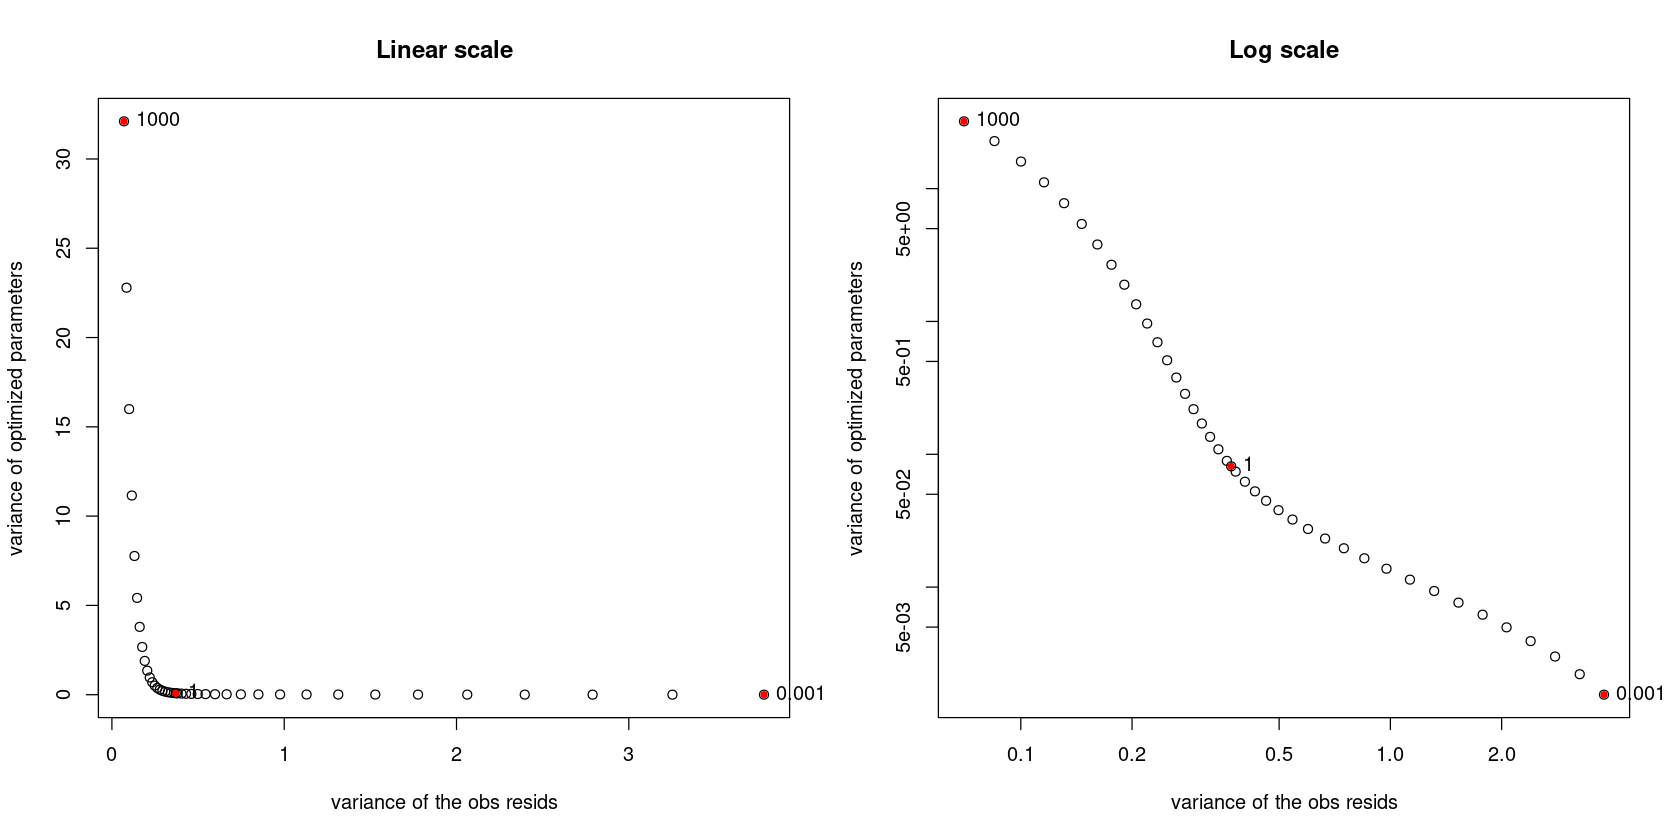

In [9]:
# Time-stamp: <hercules-login-1.hpc.msstate.edu:/work/noaa/co2/andy/Projects/enkf_summer_school/repo/ssim-ghg-2024/EnKF/L-curve/lc2.r: 26 May 2024 (Sun) 17:30:37 UTC>

source("../tools/enkf.r")
source("../tools/progress.bar.r")
source("../tools/find.indir.r")
indir <- find.indir()

# explicitly include 1.0 since for this artificial 
# case, it is the perfect configuration
alphas <-unique(sort(c(1,10^seq(-3,3,length.out=40))))

nalphas <- length(alphas)

# allocate storage for results
var.resids <- matrix(NA,nrow=1,ncol=nalphas)
var.flux <- matrix(NA,nrow=1,ncol=nalphas)
                                      
# Load sensitivity matrices (Jacobians)
if(!exists("H.orig")) {
    t0 <- proc.time()[3]
    cat("Loading Jacobians...")
    H.orig <- list()
    load(file.path(indir,"inversion_examples/jacobians/trunc_full_jacob_030624_with_dimnames_sib4_4x5_mask.rda"))
    load(file.path(indir,"inversion_examples/jacobians/jacob_bgd_021624.rda"))
    H.orig$H <- jacob*(12/44) # Andrew reports units conversion needed
    H.orig$H_fixed <- jacob_bgd[,c(2,3)]
    rm(jacob,jacob_bgd)
    cat(sprintf('%.1fs\n',proc.time()[3]-t0))
}

nobs <- dim(H.orig$H)[1]

Szd.actual <- rep(0.5,nobs) # variance in ppm^2
Szd.assumed <- Szd.actual

nparms <- 22*24 # 22 regions, 24 months

# Real covariance of unknowns
Sx <- diag(rep(1,nparms))

# The generate_ensemble() function just chooses nmemb samples from 
# the multivariate normal distribution with covariance Sx and mean 0.
# We repurpose this to choose a random truth condition here.
truth_condition <- generate_ensemble(Sx=Sx,nmemb=1)
dim(truth_condition) <- c(nparms,1)


# Perturbed observations (because Szd is supplied)
obs <- simulate_observed(H=H.orig$H, x=truth_condition, H_fixed=H.orig$H_fixed, Szd=Szd.actual)
dim(obs) <- c(nobs,1)

# Restrict to nobs randomly sampled subset of measurements. Could use
# obs_catalog or row.names of H to do more systematically-chosen
# subsets.
#
# The L-curve is typical of /under/-constrained problems, so we
# restrict to just a small number of observations.
nobs <- 200
lx <- sample(x=1:length(obs),size=nobs)
obs <- obs[lx,]
Szd.assumed <- Szd.assumed[lx]
Szd.actual <- Szd.actual[lx]
H <- H.orig$H[lx,]
H_fixed <- H.orig$H_fixed[lx,]

obs_fixed <- apply(H_fixed,c(1),sum)

pb <- progress.bar.start(nalphas)

ialpha <- 0
for (alpha in alphas) {
  ialpha <- ialpha + 1

  Sx.prior <- alpha*Sx 
  x.prior <- rep(0,nparms)
  
  
  # Kalman filter measurement update
  kf <- kf_meas_update(x=x.prior,Sx=Sx.prior,H=H,z=obs-obs_fixed,
                       Sz=diag(Szd.assumed))
  
  dobs <- matrix(simulate_observed(H=H, x=kf$x,H_fixed=H_fixed) - obs,nrow=nobs,ncol=1)
  dx <- matrix(kf$x - x.prior,nrow=nparms,ncol=1)
  
  var.resids[ialpha] <- var(as.vector(dobs))
  var.flux[ialpha] <- var(as.vector(kf$x))

  pb <- progress.bar.print(pb,ialpha)
} # alpha

progress.bar.end(pb)

# save(chi2.resids,chi2.flux,var.flux,alphas,file="lcurve.rda")

options(jupyter.plot_scale=1,repr.plot.height=7,repr.plot.width=14)
layout(matrix(1:2,nrow=1))

lx <- c(which.min(alphas),which(alphas==1),which.max(alphas))
plot(x=var.resids, y=var.flux,xlab="variance of the obs resids",ylab="variance of optimized parameters",main="Linear scale")
points(x=var.resids[lx], y=var.flux[lx],pch=20,col='red')
text(x=var.resids[lx], y=var.flux[lx],labels=alphas[lx],pos=4,xpd=NA)

plot(x=var.resids, y=var.flux,xlab="variance of the obs resids",ylab="variance of optimized parameters",log='xy',main="Log scale")
text(x=var.resids[lx], y=var.flux[lx],labels=alphas[lx],pos=4,xpd=NA)
points(x=var.resids[lx], y=var.flux[lx],pch=20,col='red')


The Transcom 3, level 1 (annual mean) inversions of Gurney et al. (2002) chose a weighting of the priors which was almost optimal. It favored agreement with measurements over a smoother solution. Different models (shown as different colored lines) have different L curves due to their differing transport, probably the strength of their mixing.

![Transcom3 level 1 L-curve image](t3l1.lcurve.png "Transcom3 level 1")

K. R. Gurney, R. M. Law, A. S. Denning, P. J. Rayner, D. Baker, P. Bousquet, L. Bruhwiler, Y.-H. Chen, P. Ciais, S. Fan, I. Y. Fung, M. Gloor, M. Heimann, K. Higuchi, J. John, T. Maki, S. Maksyutov, K. Masarie, P. Peylin, M. Prather, B. Pak, J. Randerson, J. L. Sarmiento, S. Taguchi, T. Takahashi, P. Tans, and C.-W. Yuen. Towards robust regional estimates of CO2 sources and sinks using atmospheric transport models. Nature, 415, 2002.